# Assignment 6 - Exercise 4
## Due June 11th at 14:00

Please note: 

- Read the instructions in the exercise PDF and in this notebook carefully.
- Add your solutions *only* at `YOUR CODE HERE`/`YOUR ANSWER HERE` and remove the corresponding `raise NotImplementedError()`.
- Do not chance the provided code and text, if not stated.
- Do not *add* or *delete* cells.
- Do not `import` additional functionality. 
- Before submitting: Please make sure, that your notebook can be executed from top to bottom `Menu -> Kernel -> Restart & Run all`. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from tqdm import tqdm

#  Hide warnings of LinearSVC, LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
df = pd.read_csv('cvtrain.csv')
X_train, y_train = df.drop(columns='y').to_numpy(), df[['y']].to_numpy().flatten()

In [3]:
df = pd.read_csv('cvtest.csv')
X_test, y_test = df.drop(columns='y').to_numpy(), df[['y']].to_numpy().flatten()

In [4]:
# let's have a look at these folds
k_folds = [2, 3, 5, 10]

In [5]:
# we want to choose among these hyperparameters
parameters = {'C': np.logspace(-4, 4, num=20)}

# a) Validation

In [8]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [24]:
n = X_train.shape[0]
scores = []

for k in k_folds:
    train_percentage = (k-1)/k
    
    train_n = int(np.floor(n*train_percentage))
    perm = np.random.permutation(n)
    X_shuf = X_train[perm]
    y_shuf = y_train[perm]
    xs_train, xs_val, ys_train, ys_val = X_shuf[:train_n], X_shuf[train_n:], y_shuf[:train_n], y_shuf[train_n:]
        
    logreg = LogisticRegression().fit(xs_train, ys_train)
    scores.append(logreg.score(xs_val, ys_val))
    print(f'K: {k} score: {logreg.score(xs_val, ys_val)}')

ind = np.argmax(np.array(scores))
print(f'Best score for k={k_folds[ind]}')
    

K: 2 score: 0.805
K: 3 score: 0.835820895522388
K: 5 score: 0.8125
K: 10 score: 0.925
Best score for k=10


# b) Mean and variance introduced by validation

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [27]:
# if you use the data structure
# val_acc = [[results off all replications with k=2], ..., [results off all replications with k=10]]
# the violin plots below will work automatically
val_acc = [[] for k in k_folds]
test_acc = [[] for k in k_folds]

for ind, k in enumerate(k_folds):
    train_percentage = (k-1)/k
    
    # MC estimate
    for i in range(1000):
        train_n = int(np.floor(n*train_percentage))
        perm = np.random.permutation(n)
        X_shuf = X_train[perm]
        y_shuf = y_train[perm]
        xs_train, xs_val, ys_train, ys_val = X_shuf[:train_n], X_shuf[train_n:], y_shuf[:train_n], y_shuf[train_n:]

        logreg = LogisticRegression().fit(xs_train, ys_train)
        
        val_acc[ind].append(logreg.score(xs_val, ys_val))
        test_acc[ind].append(logreg.score(X_test, y_test))
#         scores.append(logreg.score(xs_val, ys_val))
#     print(f'K: {k} score: {logreg.score(xs_val, ys_val)}')

In [28]:
for idx, k in enumerate(k_folds):
    print(f'k={k} mean val={np.mean(val_acc[idx]):.4f} ({np.std(val_acc[idx]):.4f}) \
    mean test={np.mean(test_acc[idx]):.4f} ({np.std(test_acc[idx]):.4f})')

k=2 mean val=0.8180 (0.0219)     mean test=0.8186 (0.0045)
k=3 mean val=0.8235 (0.0287)     mean test=0.8223 (0.0027)
k=5 mean val=0.8274 (0.0407)     mean test=0.8240 (0.0019)
k=10 mean val=0.8322 (0.0556)     mean test=0.8250 (0.0013)


### Violin plots offer a nice way to visualize the distributions

In [29]:
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('number of folds k')

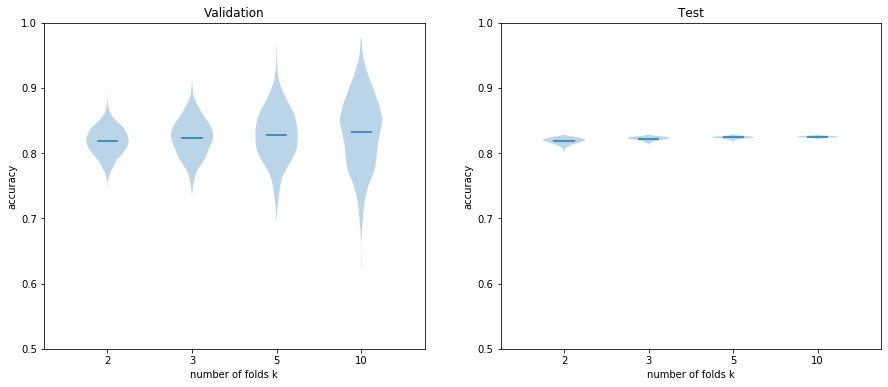

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].violinplot(val_acc, showmeans=True, showextrema=False)
ax[0].set_ylim([0.5, 1])
ax[0].set_title('Validation')
ax[0].set_ylabel('accuracy')
ax[1].violinplot(test_acc, showmeans=True, showextrema=False)
ax[1].set_ylim([0.5, 1])
ax[1].set_title('Test')
ax[1].set_ylabel('accuracy')
set_axis_style(ax[0], k_folds)
set_axis_style(ax[1], k_folds)

# c) Mean and variance introduced by cross-validation

In [32]:
from sklearn.model_selection import KFold

In [44]:
val_acc = [[] for k in k_folds]
test_acc = [[] for k in k_folds]

for ind, k in enumerate(k_folds):
    for i in range(1000):
        kf = KFold(n_splits=k, shuffle=True)
        val = []
        test = []
        for train_index, test_index in kf.split(X_train):
            xs_train, xs_val, ys_train, ys_val = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
            logreg = LogisticRegression().fit(xs_train, ys_train)
            
            val.append(logreg.score(xs_val, ys_val))
            test.append(logreg.score(X_test, y_test))

        val_acc[ind].append(sum(val)/len(val))
        test_acc[ind].append(sum(test)/len(test))

In [45]:
for idx, k in enumerate(k_folds):
    print(f'k={k} mean val={np.mean(val_acc[idx]):.4f} ({np.std(val_acc[idx]):.4f}) \
    mean test={np.mean(test_acc[idx]):.4f} ({np.std(test_acc[idx]):.4f})')

k=2 mean val=0.8180 (0.0136)     mean test=0.8185 (0.0031)
k=3 mean val=0.8219 (0.0111)     mean test=0.8221 (0.0012)
k=5 mean val=0.8264 (0.0089)     mean test=0.8240 (0.0005)
k=10 mean val=0.8304 (0.0068)     mean test=0.8250 (0.0002)


### The advantage of cross-validation becomes clear when we look at violin plots

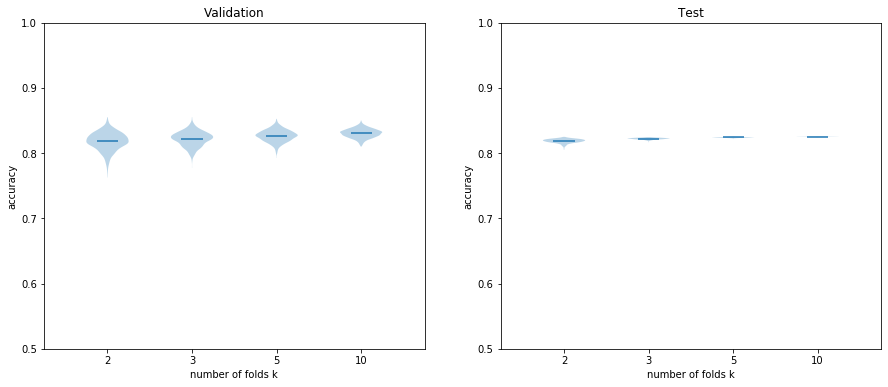

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].violinplot(val_acc, showmeans=True, showextrema=False)
ax[0].set_ylim([0.5, 1])
ax[0].set_title('Validation')
ax[0].set_ylabel('accuracy')
ax[1].violinplot(test_acc, showmeans=True, showextrema=False)
ax[1].set_ylim([0.5, 1])
ax[1].set_title('Test')
ax[1].set_ylabel('accuracy')
set_axis_style(ax[0], k_folds)
set_axis_style(ax[1], k_folds)

# d) How would you describe the influence of the parameter k in this example? 

By increasing k, in b) part we increase variance while it part c) we decrease it.

# e)  Is it fair to directly compare the procedures from b) and c)?  Argue in terms of computational costs:  How many models does each method need to train?

c) part is much more computationally ineffective as it trains one model for each fold being the test/validation one. This means that it trains k times more models than b) part.

# f) For leave-one-out, what is the variance due to the splitting of data? In this example, does leave-one-out perform better or worse than the best k found in c)?

In [47]:
from sklearn.model_selection import LeaveOneOut

In [48]:
ko = LeaveOneOut()
val = []
test = []

for train_index, test_index in ko.split(X_train):
    xs_train, xs_val, ys_train, ys_val = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
    logreg = LogisticRegression().fit(xs_train, ys_train)

    val.append(logreg.score(xs_val, ys_val))
    test.append(logreg.score(X_test, y_test))

print(f'k=1 mean val={np.mean(val_acc):.4f} ({np.std(val_acc):.4f}) \
    mean test={np.mean(test_acc):.4f} ({np.std(test_acc):.4f})')

k=1 mean val=0.8242 (0.0114)     mean test=0.8224 (0.0030)


Variance(validation) is 0.0114. K=N performs worse then KFold.